# <center>Rigid Body Replica Exchange

<h1> General Functions

In [2]:
# Imports
import os, sys, glob
import numpy as np

import ls_parsetxt
import ls_parsepdb

In [3]:
def removeEndComment(S):
    """
    Removes everything after # sign from a string
    """
    if len(S) > 1:
        i = -1
        for c in S:
            i += 1
            if c == "#":
                break
            
        return S[0 : i+1]
    else:
        return S

# Generate Input

In [57]:
# Keyword categories
# IO / Run / Thermodynamics / Worlds / Software
class RobosampleInput:
    """
    """
    
    def __init__(self, molDirs, outDir):
        """
        Sets IO parameters
        """
        # IO
        self.molDirs = molDirs
        self.outDir = outDir
        
        #
        self.flexFNs = [[None]]
        self.roots = [[None]]
        self.rootMobs = [[None]]
        self.samplers = None
    #
    
    def defineWorlds(self, flexFNs, roots, rootMobs, sampler):
        """
        param flexFNs: List of lists of flexibility files (worlds x mols)
        param roots: List of lists of roots
        param rootMobs: List of lists of root mobilities
        param sampler: list of samplers (ex HMC)
        """
        assert(len(flexFNs) == len(roots))
        assert(len(flexFNs) == len(rootMobs))
        self.flexFNs = flexFNs
        self.roots = roots
        self.rootMobs = rootMobs
    #
    
    def defineSamplers(self, sampler):
        self.sampler = sampler
    #

    def dump(self):
        print("IO: ", self.molDirs, self.outDir)
        print("Worlds: ", self.flexFNs, self.roots, self.rootMobs, self.sampler)
    #
    
    def generateInput(self, seed, nofRounds):
        pass
    #
        

    

In [58]:
IC = 0; TD = 1; RM = 2

# Fixed number of worlds per replica 
nofWorldsPerReplica = 2

regimens = np.array([IC, TD, RM], dtype = int)
allFlexFNs = ["ligand.flex.cart", "ligand.flex.7td", "ligand.flex.2td"]
allTrexFNs = ["trex.ic.dT200.dat", "trex.td.dT200.dat", "trex.rm.dT200.dat"]

# IO
molDirs = ["ala1"]
outDir = "temp"

# Worlds
flexFNs = [[allFlexFNs[0], allFlexFNs[0], allFlexFNs[1]]]
roots = [[0, 0, 0]]
rootMobs = [["Weld", "Weld", "Weld"]]
sampler ="HMC"

roboInput = RobosampleInput(molDirs, outDir)
roboInput.defineWorlds(flexFNs, roots, rootMobs, sampler)
roboInput.dump()


IO:  ['ala1'] temp
Worlds:  [['ligand.flex.cart', 'ligand.flex.cart', 'ligand.flex.7td']] [[0, 0, 0]] [['Weld', 'Weld', 'Weld']] HMC


In [4]:
# Generate input
def generateRoboInput(molDir, seed, flexFNs, trexFN, nofRounds, gbsa, writePdbs = 0):
    """
    Generate Robosample input
    """

    # Seed
    seedStr = "SEED " + str(seed)    
    
    # IO
    molStr = """
MOLECULES """ + molDir + """
PRMTOP ligand.prmtop
INPCRD ligand.rst7
OUTPUT_DIR temp
"""
    # Flexibility
    flexStr = """
RBFILE ligand.rb ligand.rb ligand.rb
ROOT_MOBILITY Weld Weld Weld
FLEXFILE """

    for FN in flexFNs:
        flexStr += FN + " "
    
    # Replica exchange
    rexStr = """
# Simulation
RUN_TYPE REX
REX_SWAP_EVERY 1
REX_FILE """ + trexFN
    
    # Worlds
    gbsaString = "0.0"
    if gbsa:
        gbsaString = "1.0"
 
    worldStr = """
ROUNDS """ + str(nofRounds) + """
ROUNDS_TILL_REBLOCK 10 10 10
WORLDS R0 R1 R2  
RANDOM_WORLD_ORDER FALSE
ROOTS 0 0 0
SAMPLER HMC HMC HMC  

TIMESTEPS 0.0007 0.0007 0.0007
MDSTEPS  10 10  10

BOOST_MDSTEPS 1 1 1
NMA_OPTION 0 0 0
SAMPLES_PER_ROUND 1 1 1
REPRODUCIBLE FALSE

# Thermodynamics
THERMOSTAT Andersen Andersen Andersen
TEMPERATURE_INI  300 300 300
TEMPERATURE_FIN  300 300 300
BOOST_TEMPERATURE  300 300 300
FFSCALE AMBER AMBER AMBER
GBSA """ + gbsaString + gbsaString + gbsaString + """

# Generalized coordinates related
FIXMAN_POTENTIAL FALSE TRUE TRUE 
FIXMAN_TORQUE FALSE TRUE TRUE

# Output
VISUAL FALSE FALSE FALSE
PRINT_FREQ  1 1 1
WRITEPDBS """ + str(writePdbs) + """ 0 0
GEOMETRY TRUE TRUE TRUE

DISTANCE 1 18
DIHEDRAL 4 6 8 14 6 8 14 16

# Software specs
THREADS 0 0 0
OPENMM TRUE
OPENMM_CalcOnlyNonbonded TRUE
NONBONDED_METHOD    0 0 0
NONBONDED_CUTOFF    1.2 1.2 1.2
"""

    return (seedStr + molStr + flexStr + rexStr + worldStr)

<h2> Generate inputs </h2>

In [5]:


flexFNs = [allFlexFNs[0], allFlexFNs[0], allFlexFNs[1]]
trexFN = allTrexFNs[1]
print(flexFNs)

nofRounds = 10000
gbsa = False

seeds = np.array(range(10), dtype = int)
seeds += 2000
print(seeds)

simType = "td"
dT = int(200.0)
for seed in seeds:
    FN = "inp." + simType + ".dT" + str(dT) + "." + str(seed)
    FContent = generateRoboInput("ala1", seed, flexFNs, trexFN, nofRounds, gbsa, writePdbs = 0)
    with open(FN, 'w') as F:
        F.write(FContent)

['ligand.flex.cart', 'ligand.flex.cart', 'ligand.flex.7td']
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009]


# Analyze Output

In [6]:
!ls

ala1		   inp.td.dT200.2007	   temp.png
inp.ic.dT200.1001  inp.td.dT200.2008	   trex.ic.dT200.dat
inp.rm.dT200.3001  inp.td.dT200.2009	   trex.rm.dT200.dat
inp.td.dT200.2000  line.td.dT200.2001.raw  trex.td.dT200.dat
inp.td.dT200.2001  out			   xrate.ic.dT200.1001
inp.td.dT200.2002  out.ic.dT200.1001	   xrate.rm.dT200.3001
inp.td.dT200.2003  out.rm.dT200.3001	   xrate.td.dT200.2001
inp.td.dT200.2004  out.td.dT200.2001	   xrate.td.dT200.r3.2001
inp.td.dT200.2005  rexz.ipynb
inp.td.dT200.2006  temp


In [16]:
FNList = glob.glob("out.*")
#print(FNList)

nofWorlds = 0
with open("inp.td.dT200.2001", "r") as F:
    all_lines = F.readlines()
    linei = -1
    for line in all_lines:
        linei += 1
        line = removeEndComment(line)
        if(len(line) > 1):
            words = line.split()
            if words[0][0] != "#":
                if words[0] == "WORLDS":
                    nofWorlds = len(words) - 1


print("nofWorlds", nofWorlds)   

nofWorlds = 2

nofWorlds 3


In [17]:
 


nofReplicas = 0
Ts = np.zeros((1))
worlds = np.zeros((1, nofWorldsPerReplica))
tss = np.zeros((1, nofWorldsPerReplica))
mdsteps = np.zeros((1, nofWorldsPerReplica))
spr = np.zeros((1, nofWorldsPerReplica))

with open("trex.td.dT200.dat", "r") as F:
    all_lines = F.readlines()
    linei = -1
    for line in all_lines:
        linei += 1
        words = line.split()
        if words[0][0] != "#":
            if words[0] == "NOF_REPLICAS":
                nofReplicas = int(words[1])
                print("nofReplicas", nofReplicas)
                Ts.resize((nofReplicas))
                worlds.resize((nofReplicas, nofWorldsPerReplica)) # HARDCODED !!!!
                tss.resize((nofReplicas, nofWorldsPerReplica)) # HARDCODED !!!!
                mdsteps.resize((nofReplicas, nofWorldsPerReplica)) # HARDCODED !!!!
                spr.resize((nofReplicas, nofWorldsPerReplica)) # HARDCODED !!!!
            else:
                if not nofReplicas:
                    "NOF_REPLICAS not set first in grex file."
                    break
                else:
                    K = int(words[0])
                    if words[1] == "TEMPERATURE":
                        Ts[K] = float(words[2])
                        
                    elif words[1] == "WORLD_INDEXES":
                        for wi in range(nofWorldsPerReplica): # HARDCODED !!!
                            worlds[K, wi] = words[2+wi]

                    elif words[1] == "TIMESTEPS":
                        for wi in range(nofWorldsPerReplica): # HARDCODED !!!
                            tss[K, wi] = words[2+wi]
                            
                    elif words[1] == "MDSTEPS":
                        for wi in range(nofWorldsPerReplica): # HARDCODED !!!
                            mdsteps[K, wi] = words[2+wi]
                            
                    elif words[1] == "SAMPLES_PER_ROUND":
                        for wi in range(nofWorldsPerReplica): # HARDCODED !!!
                            spr[K, wi] = words[2+wi]                        
                                        
print("Ts", Ts)
print("worlds", worlds)
print("tss", tss)
print("mdsteps", mdsteps)
print("spr", spr)



nofReplicas 4
Ts [300. 500. 700. 900.]
worlds [[0. 1.]
 [0. 2.]
 [0. 2.]
 [0. 2.]]
tss [[0.0007 0.0007]
 [0.0007 0.003 ]
 [0.0007 0.003 ]
 [0.0007 0.003 ]]
mdsteps [[  0. 300.]
 [  0.  70.]
 [  0.  70.]
 [  0.  70.]]
spr [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


In [18]:
# Get output
outData = []
batchi = -1
outD = np.zeros((10000, nofReplicas, nofWorldsPerReplica, 8)) * np.nan
with open("out.td.dT200.2001", "r") as F:
#with open("out", "r") as F:
    all_lines = F.readlines()
    linei = -1
    for line in all_lines:
        linei += 1
        line.replace(" ", "").replace(",", "",100)
        words = line.split()
        if  (words[0] == "REX") and (words[1] == "batch"):
            batchi += 1
            outData.append([])
            replicai = -1
        elif (words[0] == "REX") and (words[1] == "replica"):
            replicai += 1
            outData[batchi].append([])
            worldi = -1
            
        elif (words[0] == "Temperature") and (words[1] == "set") and (words[2] == "to"):
            for j in range(nofWorldsPerReplica): # HARDCODED !!!
                outD[batchi][replicai][j][0] = float(words[3])
                
        elif (words[0] == "World") and (words[2] == "NU"):
            worldi += 1
            #outData[batchi][replicai].append([])
        elif(words[0] == "pe_o"):
            pe_o = float(words[1].replace(",", ""))
            pe_n = float(words[3].replace(",", ""))
            #outData[batchi][replicai][worldi].append(pe_o)
            #outData[batchi][replicai][worldi].append(pe_n)
            outD[batchi][replicai][worldi][1] = pe_o
            outD[batchi][replicai][worldi][2] = pe_n

        elif(words[0] == "ke_prop"):
            ke_prop = float(words[1].replace(",", ""))
            ke_n = float(words[3].replace(",", ""))
            #outData[batchi][replicai][worldi].append(ke_prop)
            #outData[batchi][replicai][worldi].append(ke_n)
            outD[batchi][replicai][worldi][3] = ke_prop
            outD[batchi][replicai][worldi][4] = ke_n

        elif(words[0] == "fix_o"):
            fix_o = float(words[1].replace(",", ""))
            fix_n = float(words[3].replace(",", ""))
            #outData[batchi][replicai][worldi].append(fix_o)
            #outData[batchi][replicai][worldi].append(fix_n)
            outD[batchi][replicai][worldi][5] = fix_o
            outD[batchi][replicai][worldi][6] = fix_n


        elif (len(words) > 2) and (words[2] == "(metropolis-hastings)"):
            if words[1] == "accepted":
                acc = 1.0
            else:
                acc = 0.0
            #outData[batchi][replicai][worldi].append(acc)
            outD[batchi][replicai][worldi][7] = acc

            
#        if linei > 500:
#            print(outData)
#            break



Extract Thermodynamic States

In [19]:
Ix_T = 0
Ix_pe_o = 1
Ix_pe_n = 2
Ix_ke_prop = 3
Ix_ke_n = 4
Ix_fix_o = 5
Ix_fix_n = 6
Ix_acc = 7

#k = 0
#print(outD[:,k,0,Ix_T])

thermoStateD = np.zeros((10000, nofReplicas, nofWorldsPerReplica, 8)) * np.nan
mix = np.zeros((10000, nofReplicas)) * np.nan

thermoIx = 0
thermoT = Ts[0]
batchi = -1
for D in outD:
    batchi += 1
    replicai = -1
    for replica in D:
        replicai += 1
        for tix in range(Ts.size):
            if replica[0, 0] == Ts[tix]:
                thermoStateD[batchi, tix] = replica
                mix[batchi, tix] = replicai
                #mix[batchi, replicai] = tix       
            

<h2> Kinetic Energy

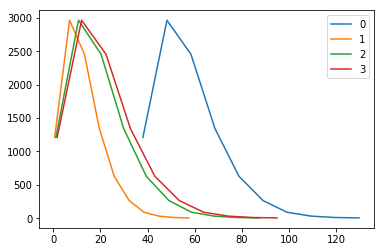

In [21]:
import matplotlib
import matplotlib.pyplot as plt

# Kinetic energy
KHists = []
for k in range(nofReplicas):
    h = np.histogram(thermoStateD[:,k,1,Ix_ke_prop][0:9000])
    KHists.append(h)
fig, axs = plt.subplots(1, 1)
for k in range(nofReplicas):
    plt.plot(KHists[k][1][:-1], h[0], label = str(k))
    #plt.plot(thermoStates[:,k,1,Ix_ke_prop][0:9000], label = "T")
plt.legend()
plt.show()


<h1>  Potential Energy

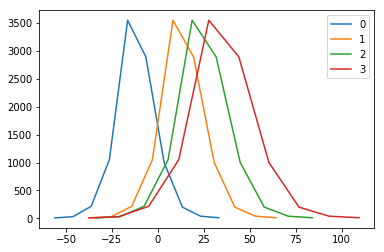

In [22]:
# Kinetic energy
UHists = []
for k in range(nofReplicas):
    h = np.histogram(thermoStateD[:,k,0,Ix_pe_o][0:9000])
    UHists.append(h)
fig, axs = plt.subplots(1, 1)
for k in range(nofReplicas):
    plt.plot(UHists[k][1][:-1], h[0], label = str(k))
    #plt.plot(thermoStates[:,k,1,Ix_ke_prop][0:9000], label = "T")
plt.legend()
plt.show()

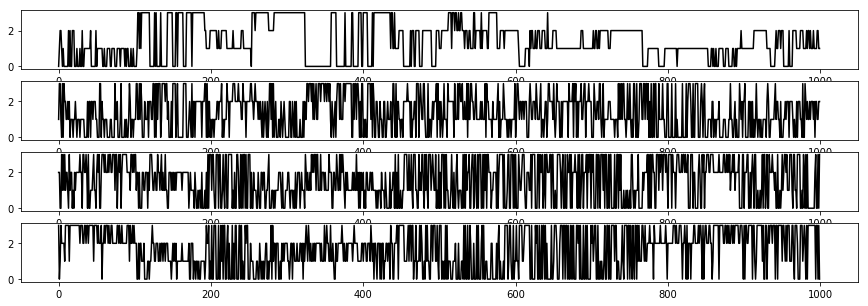

In [23]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, axs = plt.subplots(4, 1)
for k in range(nofReplicas):
    axs[k].plot(range(len(mix[:,k][::10])), mix[:,k][::10], color = 'black')
    #axs[k].scatter(range(len(mix[:,k][::10])), mix[:,k][::10], color = 'black')

    
plt.show()


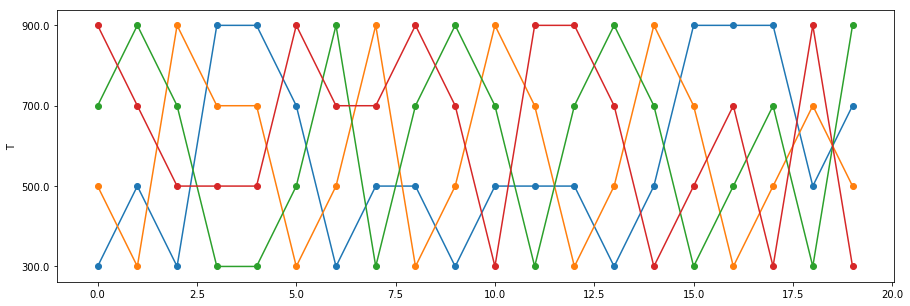

In [24]:
fig, axs = plt.subplots(1, 1)
for k in range(nofReplicas):
    axs.scatter(range(len(mix[:,k][0:20])), mix[:,k][0:20])
    axs.plot(range(len(mix[:,k][0:20])), mix[:,k][0:20])
    axs.set_ylabel("T")
    axs.set_yticks(range(Ts.size))
    axs.set_yticklabels(Ts)
    
plt.show()

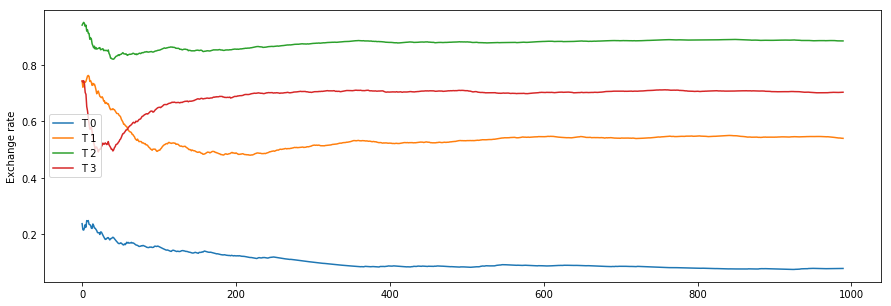

In [60]:
#print(mix.shape)     
xrate = np.zeros(mix.shape, dtype = float)
# Create v with arange ... is better
v = np.ones(xrate.shape, dtype = float)
for i in range(1, mix.shape[0]):
    for j in range(mix.shape[1]):
        v[i, j] += v[i-1, j]
        # Check if exchange happend
        if mix[i-1, j] != mix[i, j]:
            xrate[i, j] = xrate[i-1, j] + 1.0
        else:
            xrate[i, j] = xrate[i-1, j]


xrate /= v

colors = ["blue"]

fig, axs = plt.subplots(1, 1)
for k in range(nofReplicas):
    axs.plot(xrate[:,k][::10][10:], label = "T " + str(k))
    axs.set_ylabel("Exchange rate")
    
plt.legend()    
plt.show()